In [50]:
# pre processamento de dados
import pandas as pd
import numpy as np

# deep learning framework
import torch
from torch import nn, optim
import torch.nn.functional as F

# scalers e métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Carregando o dataset

In [51]:
df = pd.read_csv('btc.csv', index_col='Date', parse_dates=True)
df.drop(columns=['Symbol'], inplace=True)
df.sort_values(by='Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume From,Volume To
Date,,,,,,
2014-12-01,300.0,370.0,300.00,370.0,0.05656,19.53
2014-12-02,370.0,378.0,370.00,378.0,15.01000,5675.07
2014-12-03,378.0,378.0,377.01,378.0,0.54660,206.52
2014-12-04,378.0,378.0,377.10,377.1,0.01000,3.77
2014-12-05,377.1,377.1,377.10,377.1,0.00000,0.00


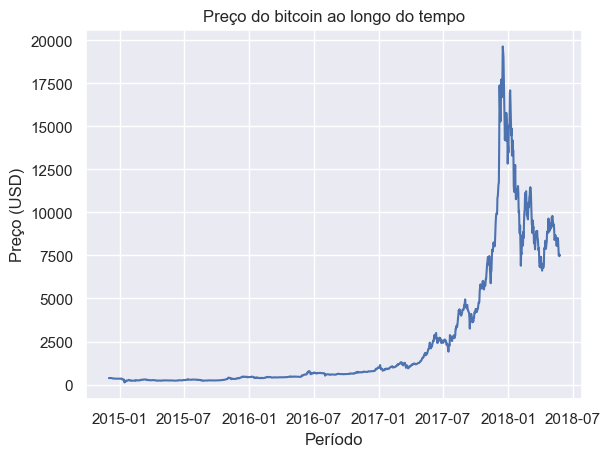

In [52]:
plt.plot(df.Close)
plt.xlabel("Período")
plt.ylabel("Preço (USD)")
plt.title("Preço do bitcoin ao longo do tempo")
plt.show()

In [53]:
# separando features e labels
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((1273, 5), (1273,))

In [54]:
mm = MinMaxScaler()
ss = StandardScaler()

X_scaled = ss.fit_transform(X)
y_scaled = mm.fit_transform(y.reshape(-1, 1))

In [55]:
# pega os n_steps_in input_sequences mais recentes para prever os próximos n_steps_out output_sequence
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # encontra o final das sequências de input e output
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences): break
        # coleta input_sequence e output_sequence
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_scaled, y_scaled, 100, 50)
print(X_ss.shape, y_mm.shape)

(1125, 100, 5) (1125, 50)


In [56]:
X_ss[0]

array([[-0.58087524, -0.56218474, -0.58526647, -1.03228266, -0.42210713],
       [-0.56238099, -0.56016332, -0.5655982 , -1.0307777 , -0.42205355],
       [-0.56026736, -0.56016332, -0.56362856, -1.03223334, -0.42210536],
       [-0.56026736, -0.56016332, -0.56360328, -1.03228734, -0.42210728],
       [-0.56050514, -0.56039073, -0.56360328, -1.03228835, -0.42210732],
       [-0.56050514, -0.56016332, -0.56360328, -1.03228684, -0.42210727],
       [-0.56026736, -0.56016332, -0.5633504 , -1.03228835, -0.42210732],
       [-0.56026736, -0.56016332, -0.56419333, -1.0322647 , -0.42210648],
       [-0.56105997, -0.56092136, -0.56419333, -1.03228835, -0.42210732],
       [-0.56105997, -0.55510977, -0.56826747, -1.03228634, -0.42210725],
       [-0.56489092, -0.56458518, -0.56826747, -1.03228835, -0.42210732],
       [-0.56489092, -0.55991065, -0.57121771, -1.03197133, -0.42209675],
       [-0.56766506, -0.5672383 , -0.57121771, -1.03228835, -0.42210732],
       [-0.56766506, -0.5672383 , -0.5

In [57]:
y_mm[0]

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [58]:
y_scaled[99:149].squeeze(1)

array([0.00883564, 0.00904403, 0.00901741, 0.00855095, 0.00841219,
       0.0085745 , 0.0088085 , 0.00854429, 0.00709217, 0.00733641,
       0.00735842, 0.00726216, 0.00768049, 0.00745571, 0.00659549,
       0.00650282, 0.00666462, 0.00658884, 0.0068341 , 0.0063277 ,
       0.00658423, 0.00641372, 0.00651562, 0.00688582, 0.00694726,
       0.00690579, 0.00724322, 0.00704403, 0.00694675, 0.0064849 ,
       0.00633129, 0.00593241, 0.00604864, 0.00604352, 0.00604352,
       0.00514747, 0.005319  , 0.00558577, 0.00529954, 0.00532463,
       0.0053277 , 0.00537839, 0.00588377, 0.00583717, 0.00591347,
       0.00575422, 0.00548182, 0.00514593, 0.00548899, 0.00540092])

In [60]:
def divisao_treino(percent_train):
    train_size = int(len(X_scaled)*percent_train)
    test_size = len(X_scaled) - train_size
    X_train = X_ss[:-(test_size)]
    X_test = X_ss[-(test_size):]

    y_train = y_mm[:-(test_size)]
    y_test = y_mm[-(test_size):]
    return X_train, X_test, y_train, y_test, train_size, test_size


In [61]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.80)

In [62]:
def preprocessing(X_train, X_test, y_train, y_test):
    X_train_tensors = torch.Tensor(X_train)
    X_test_tensors = torch.Tensor(X_test)

    y_train_tensors = torch.Tensor(y_train)
    y_test_tensors = torch.Tensor(y_test)
    X_train_tensors.requires_grad = True
    X_test_tensors.requires_grad = True

    y_train_tensors.requires_grad = True
    y_test_tensors.requires_grad = True
    
    X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
    X_test_tensors_final = torch.reshape(X_test_tensors,  
                                        (X_test_tensors.shape[0], 100, 
                                        X_test_tensors.shape[2])) 
    return X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors


X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [63]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]


X.iloc[-149:-145]

,Open,High,Low,Volume From,Volume To
Date,,,,,
2017-12-29,14450.01,15105.34,14041.81,17235.04,251682459.9
2017-12-30,14565.05,14639.79,12500.00,25286.65,340875743.9
2017-12-31,12839.99,14280.26,12633.80,17428.57,234823165.7
2018-01-01,13863.13,13889.00,12952.50,11484.01,154169331.5


In [64]:
y_check[-1]

array([6894.01, 7020.01, 6771.13, 6824.99, 6942.99, 7916.  , 7893.19,
       8003.11, 8355.25, 8048.93, 7892.1 , 8152.05, 8274.  , 8866.27,
       8915.42, 8795.01, 8931.3 , 9648.  , 8865.98, 9272.11, 8922.55,
       9329.99, 9389.01, 9243.83, 9072.29, 9190.48, 9725.74, 9685.  ,
       9800.  , 9600.  , 9353.  , 9177.81, 9300.08, 9010.51, 8403.33,
       8475.  , 8686.1 , 8670.  , 8477.46, 8344.  , 8059.  , 8238.51,
       8235.6 , 8516.86, 8393.44, 7987.7 , 7505.  , 7584.15, 7459.11,
       7520.  ])

In [65]:
df.Close.values[-50:]

array([6894.01, 7020.01, 6771.13, 6824.99, 6942.99, 7916.  , 7893.19,
       8003.11, 8355.25, 8048.93, 7892.1 , 8152.05, 8274.  , 8866.27,
       8915.42, 8795.01, 8931.3 , 9648.  , 8865.98, 9272.11, 8922.55,
       9329.99, 9389.01, 9243.83, 9072.29, 9190.48, 9725.74, 9685.  ,
       9800.  , 9600.  , 9353.  , 9177.81, 9300.08, 9010.51, 8403.33,
       8475.  , 8686.1 , 8670.  , 8477.46, 8344.  , 8059.  , 8238.51,
       8235.6 , 8516.86, 8393.44, 7987.7 , 7505.  , 7584.15, 7459.11,
       7520.  ])

In [67]:


class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = (torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn[-1]
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [69]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item()))

## Teste inicial com nossa `LSTM`

```python
# Aqui utilizaremos uma arquitetura simples e uma escolha de hiperparâmetros mais básica, entre esses hiperparâmetros temos:
```

- `épocas`: 1000
- `learning rate`: 0.001
- `hidden size`: 10
- `layers`: 3

In [70]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 5 # number of features
hidden_size = 10 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [71]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [72]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)



Epoch: 0, train loss: 0.01234, test loss: 0.23241
Epoch: 100, train loss: 0.00033, test loss: 0.13029


KeyboardInterrupt: 

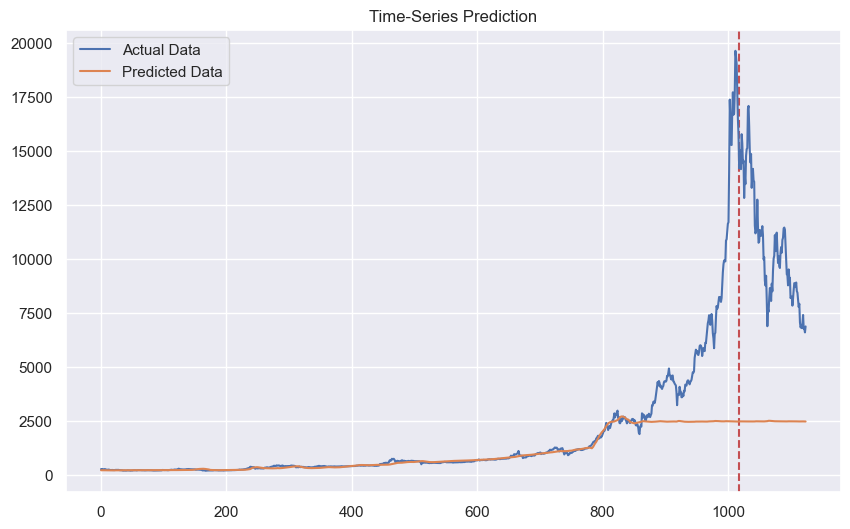

In [ ]:
def    
    df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
    df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
    # split the sequence
    df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
    # converting to tensors
    df_X_ss = (torch.Tensor(df_X_ss))
    df_y_mm = (torch.Tensor(df_y_mm))
    # reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

    train_predict = lstm(df_X_ss) # forward pass
    data_predict = train_predict.data.numpy() # numpy conversion
    dataY_plot = df_y_mm.data.numpy()

    data_predict = mm.inverse_transform(data_predict) # reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)
    true, preds = [], []
    for i in range(len(dataY_plot)):
        true.append(dataY_plot[i][0])
    for i in range(len(data_predict)):
        preds.append(data_predict[i][0])
    plt.figure(figsize=(10,6)) #plotting
    plt.axvline(x=train_size, c='r', linestyle='--') # size of the training set

    plt.plot(true, label='Actual Data') # actual plot
    plt.plot(preds, label='Predicted Data') # predicted plot
    plt.title('Time-Series Prediction')
    plt.legend()
    plt.savefig("whole_plot.png", dpi=300)
    plt.show()

In [ ]:
# salvando o modelo
torch.save(lstm.state_dict(), 'model.pth')

## Resultados do Teste `1`

```python
# percebemos um modelo que performou de forma exemplar em seus dados de treino, porém deixou muito a desejar nos dados de teste, portanto podemos visar uma melhoria do modelo ao aplicar estratégias para lidar com o overfit do mesmo.
```

#### `Overfit`

- Aumentar a quantidade de dados
- Diminuir a complexidade
- Early Stopping
- Dropout

---

## Segundo teste para sanar `Overfit`

```python

# Aqui utilizaremos a estratégia de aumentar a quantidade de dados de treinamento do modelo, visando reduzir o overfit, a arquitetura em si será a mesma

In [46]:
# salvando o modelo
torch.save(lstm.state_dict(), 'model.pth')

In [75]:
X_train, X_test, y_train, y_test, train_size, test_size  = divisao_treino(0.96)
X_train_tensors_final, X_test_tensors_final, y_train_tensors, y_test_tensors = preprocessing(X_train, X_test, y_train, y_test)

In [76]:
def instanciate_lstm(modelo,n_epochs,learning_rate, hidden_size, num_layers):
    n_epochs = n_epochs # 1000 epochs
    learning_rate = learning_rate # 0.001 lr

    input_size = 5 # number of features
    hidden_size = hidden_size # number of features in hidden state
    num_layers = num_layers # number of stacked lstm layers

    num_classes = 50 # number of output classes 

    modelo = LSTM(num_classes, 
                input_size, 
                hidden_size, 
                num_layers)
    return modelo, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes

def setup_optimizers(lstm, learning_rate):
    loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
    optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    return loss_fn, optimiser



In [77]:
lstm, n_epochs, learning_rate, input_size, hidden_size, num_layers, num_classes = instanciate_lstm(lstm, 1000, 0.001, 10, 3)

loss_fn, optimiser = setup_optimizers(lstm, learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.05590, test loss: 0.17719
Epoch: 100, train loss: 0.00418, test loss: 0.03152


KeyboardInterrupt: 

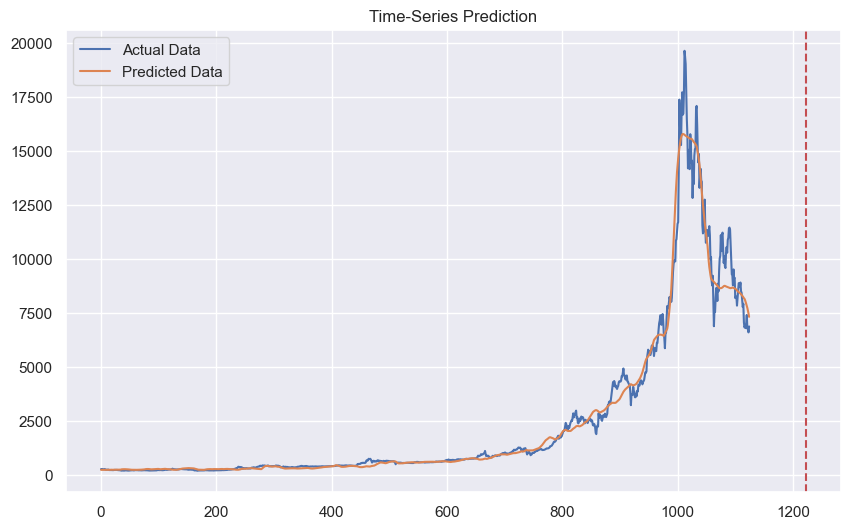

In [49]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = (torch.Tensor(df_X_ss))
df_y_mm = (torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_size, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()